# Bitcoin Volatility Prediction with Explainable AI 📊

## Project Overview

This notebook explores Bitcoin volatility prediction using multiple machine learning models with comprehensive visualizations and explainability analysis.

**Key Objectives:**
- Forecast next-day Bitcoin volatility
- Compare multiple ML models (Linear Regression, Random Forest, XGBoost, LSTM)
- Provide model explainability through SHAP values
- Visualize patterns and predictions

**Dataset:** BTC-USD daily candles from Yahoo Finance (2019-present)

**Target Variable:** Next-day realized volatility = (High - Low) / Open

---


## 1. Setup & Imports 🔧


In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set default figure size
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


✅ Imports successful!
NumPy version: 1.26.4
Pandas version: 2.2.3


## 2. Data Collection 📥

We'll fetch Bitcoin price data from Yahoo Finance. The data includes:
- **Open, High, Low, Close prices**
- **Volume**
- **Daily frequency** from 2019 onwards

**Important:** If you don't have yfinance installed, run the next cell first to install it.

**Note:** Using Yahoo Finance because Binance API is blocked in some regions (HTTP 451 error).


### 2.1 Install yfinance (Run once)

**Note:** After running this cell, you may need to restart your kernel before yfinance is available.


In [4]:
# Install yfinance package
%pip install yfinance



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Kefan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### 2.2 Load Bitcoin Data from Yahoo Finance


In [5]:
# Try to use yfinance for data (more reliable than Binance)
try:
    import yfinance as yf
    
    print("Loading Bitcoin data from Yahoo Finance...\n")
    
    # Download BTC-USD data
    ticker = yf.Ticker("BTC-USD")
    df_raw = ticker.history(start="2019-01-01", interval="1d")
    
    # Format to match expected structure
    df_raw = df_raw.reset_index()
    df_raw.columns = df_raw.columns.str.lower()
    
    # Create clean dataframe
    df = pd.DataFrame({
        'date': pd.to_datetime(df_raw['date']).dt.date,
        'open': df_raw['open'],
        'high': df_raw['high'],
        'low': df_raw['low'],
        'close': df_raw['close'],
        'volume': df_raw['volume']
    })
    
    # Remove any NaN values
    df = df.dropna().reset_index(drop=True)
    
    # Save to CSV for future use
    df.to_csv('btcusdt_daily.csv', index=False)
    print("✓ Data cached to btcusdt_daily.csv")
    
except ImportError:
    print("⚠️ yfinance not installed. Trying to load from cached file...")
    try:
        df = pd.read_csv('btcusdt_daily.csv')
        df['date'] = pd.to_datetime(df['date']).dt.date
        print("✓ Loaded from cache")
    except FileNotFoundError:
        print("❌ No cached data found. Please install yfinance: pip install yfinance")
        raise

print(f"\n✅ Data loaded successfully!")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {len(df)}")
print(f"Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")


Loading Bitcoin data from Yahoo Finance...

✓ Data cached to btcusdt_daily.csv

✅ Data loaded successfully!
Date range: 2019-01-01 to 2025-11-03
Total days: 2498
Price range: $3399.47 - $124752.53


### 2.3 Quick Data Preview


In [6]:
# Display first few rows
df.head(10)


,date,open,high,low,close,volume
0,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,4324200990
1,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,5244856836
2,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,4530215219
3,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,4847965467
4,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,5137609824
5,2019-01-06,3836.519043,4093.297363,3826.513184,4076.632568,5597027440
6,2019-01-07,4078.584961,4092.613525,4020.894043,4025.248291,5228625637
7,2019-01-08,4028.472168,4109.020996,3996.955322,4030.847900,5306593305
8,2019-01-09,4031.552002,4068.403564,4022.662842,4035.296387,5115905225
9,2019-01-10,4034.411377,4064.066650,3659.174561,3678.924561,6874143796


### 2.4 Visualize Raw Price Data


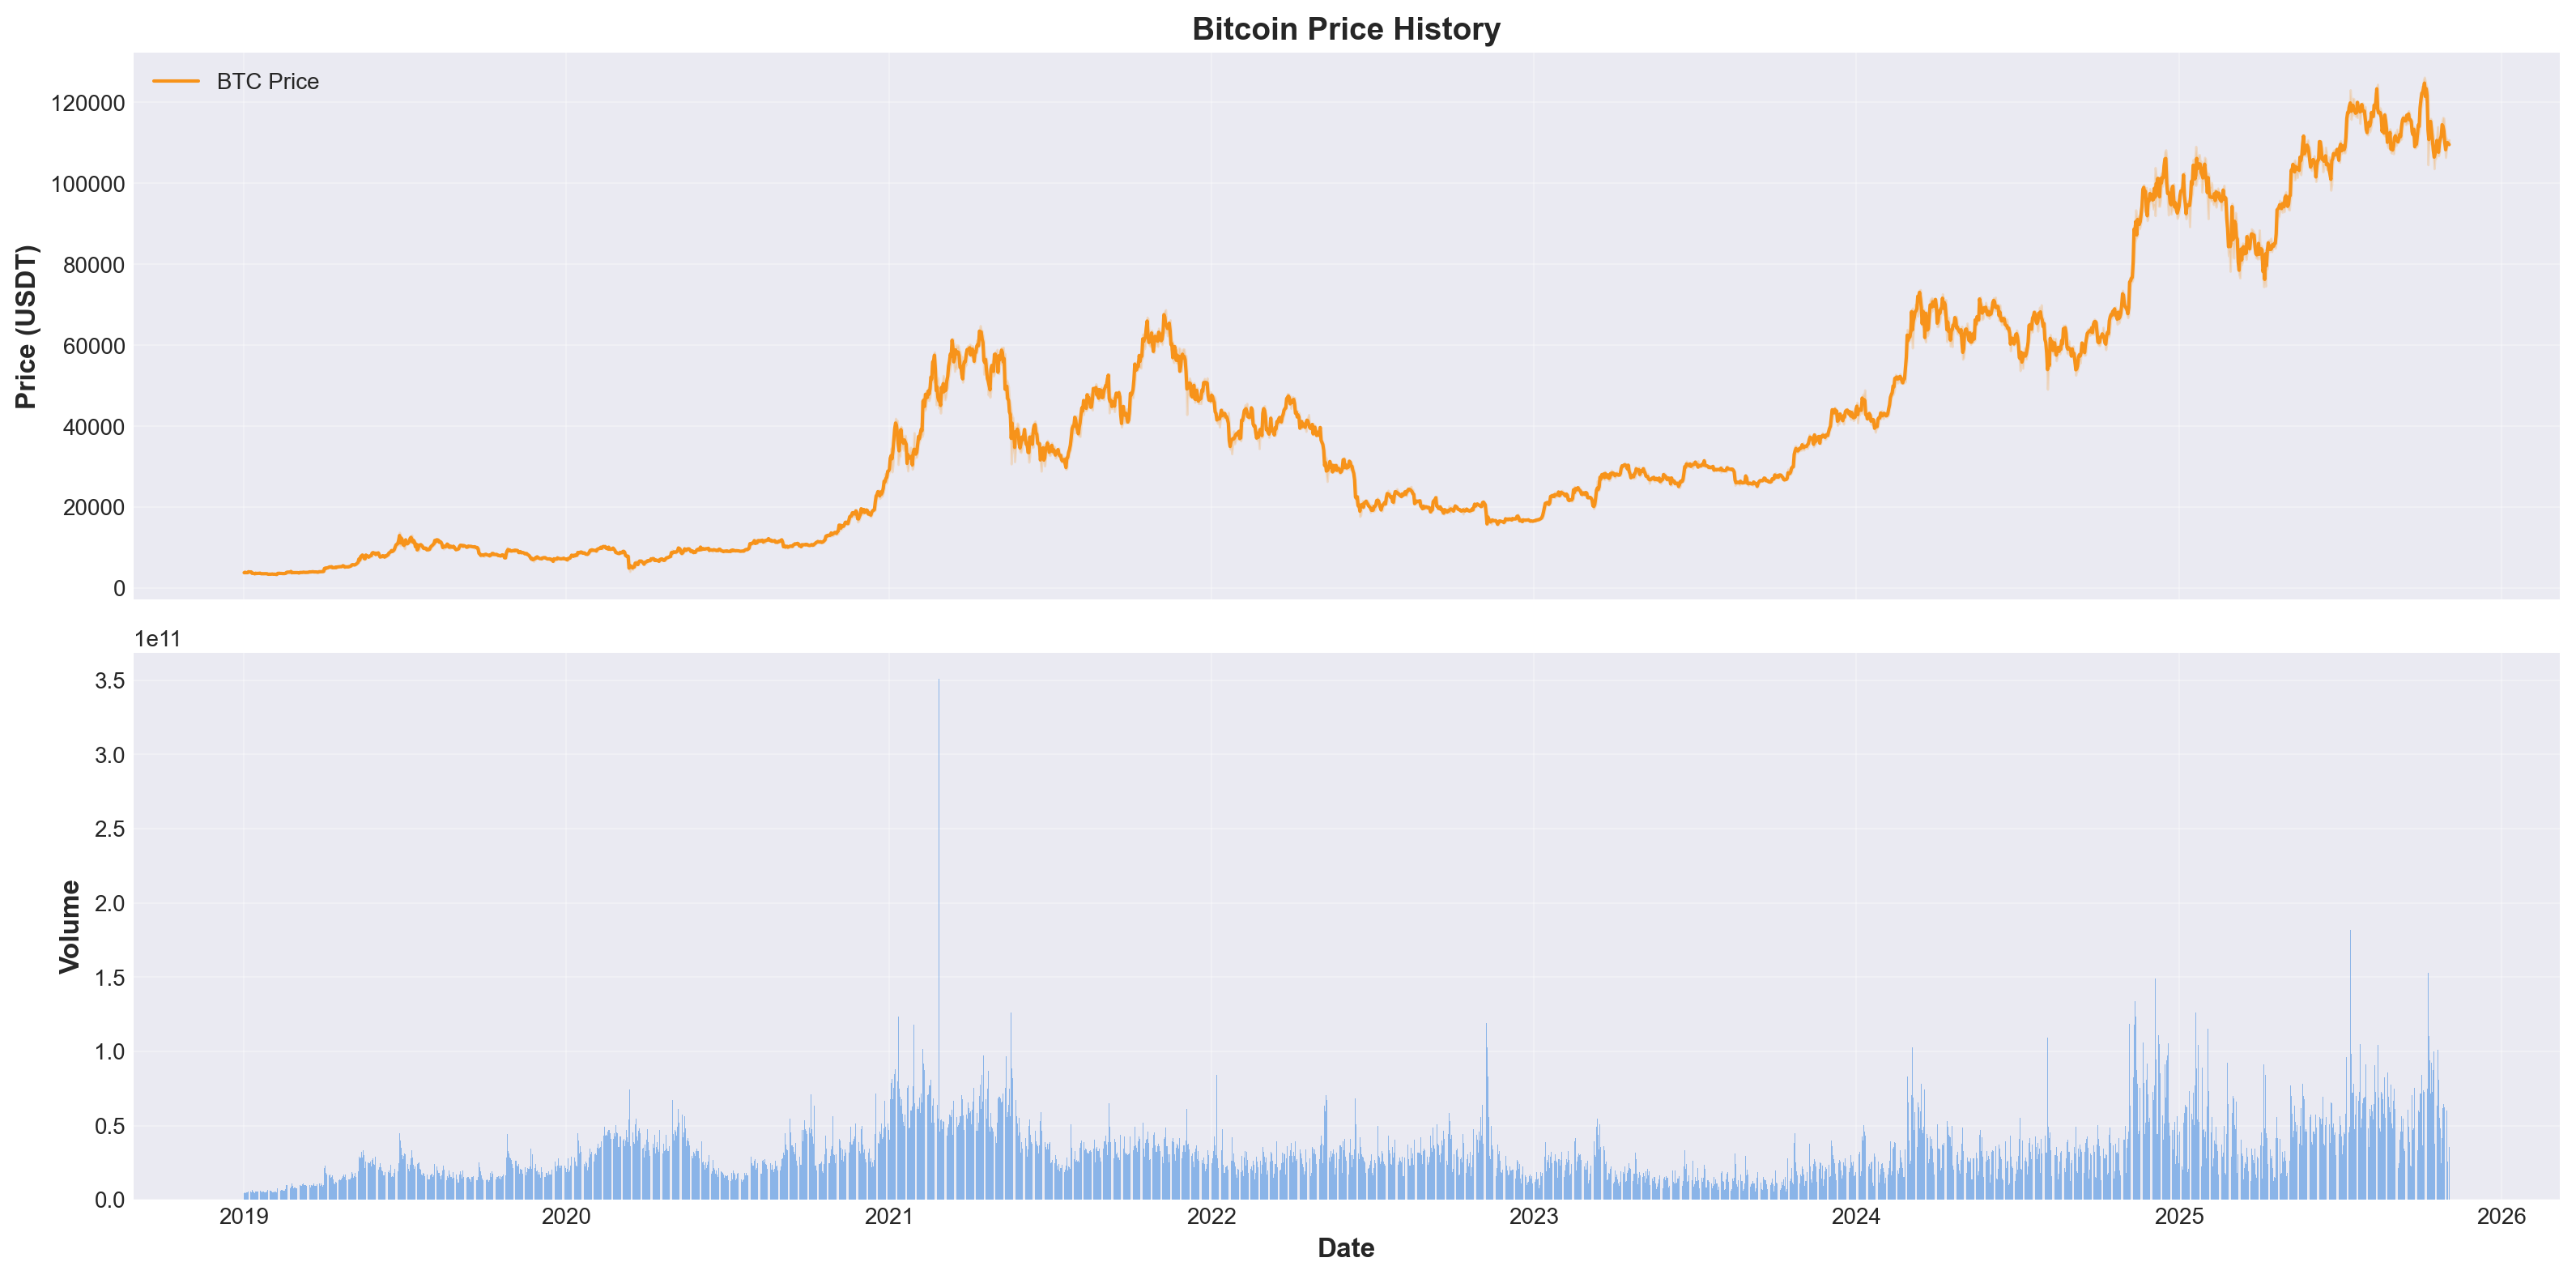

In [7]:
# Price history with volume
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Price chart
ax1.plot(df['date'], df['close'], linewidth=1.5, color='#F7931A', label='BTC Price')
ax1.fill_between(df['date'], df['low'], df['high'], alpha=0.2, color='#F7931A')
ax1.set_ylabel('Price (USDT)', fontsize=12, fontweight='bold')
ax1.set_title('Bitcoin Price History', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Volume chart
ax2.bar(df['date'], df['volume'], color='#4A90E2', alpha=0.6, width=0.8)
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Feature Engineering ⚙️

We'll create 50+ technical indicators including:
- **Price Features:** Returns, Moving Averages, MACD, Bollinger Bands
- **Volume Features:** Volume ratios and changes  
- **Volatility Features:** Historical volatility measures
- **Momentum Features:** RSI, ROC, Momentum indicators


In [8]:
from feature_engineering import create_all_features, get_feature_columns

print("Creating features...\n")
df_features = create_all_features(df)
feature_cols = get_feature_columns()

print(f"\n✅ Feature engineering complete!")
print(f"Total features created: {len(feature_cols)}")
print(f"Usable samples: {len(df_features)}")


Creating features...

Creating features...
✓ Price features added
✓ Volume features added
✓ Volatility features added
✓ Momentum features added
✓ Dropped 74 rows with NaN values
✓ Final dataset: 2424 rows, 66 columns

✅ Feature engineering complete!
Total features created: 48
Usable samples: 2424


### 3.1 Visualize Volatility Patterns


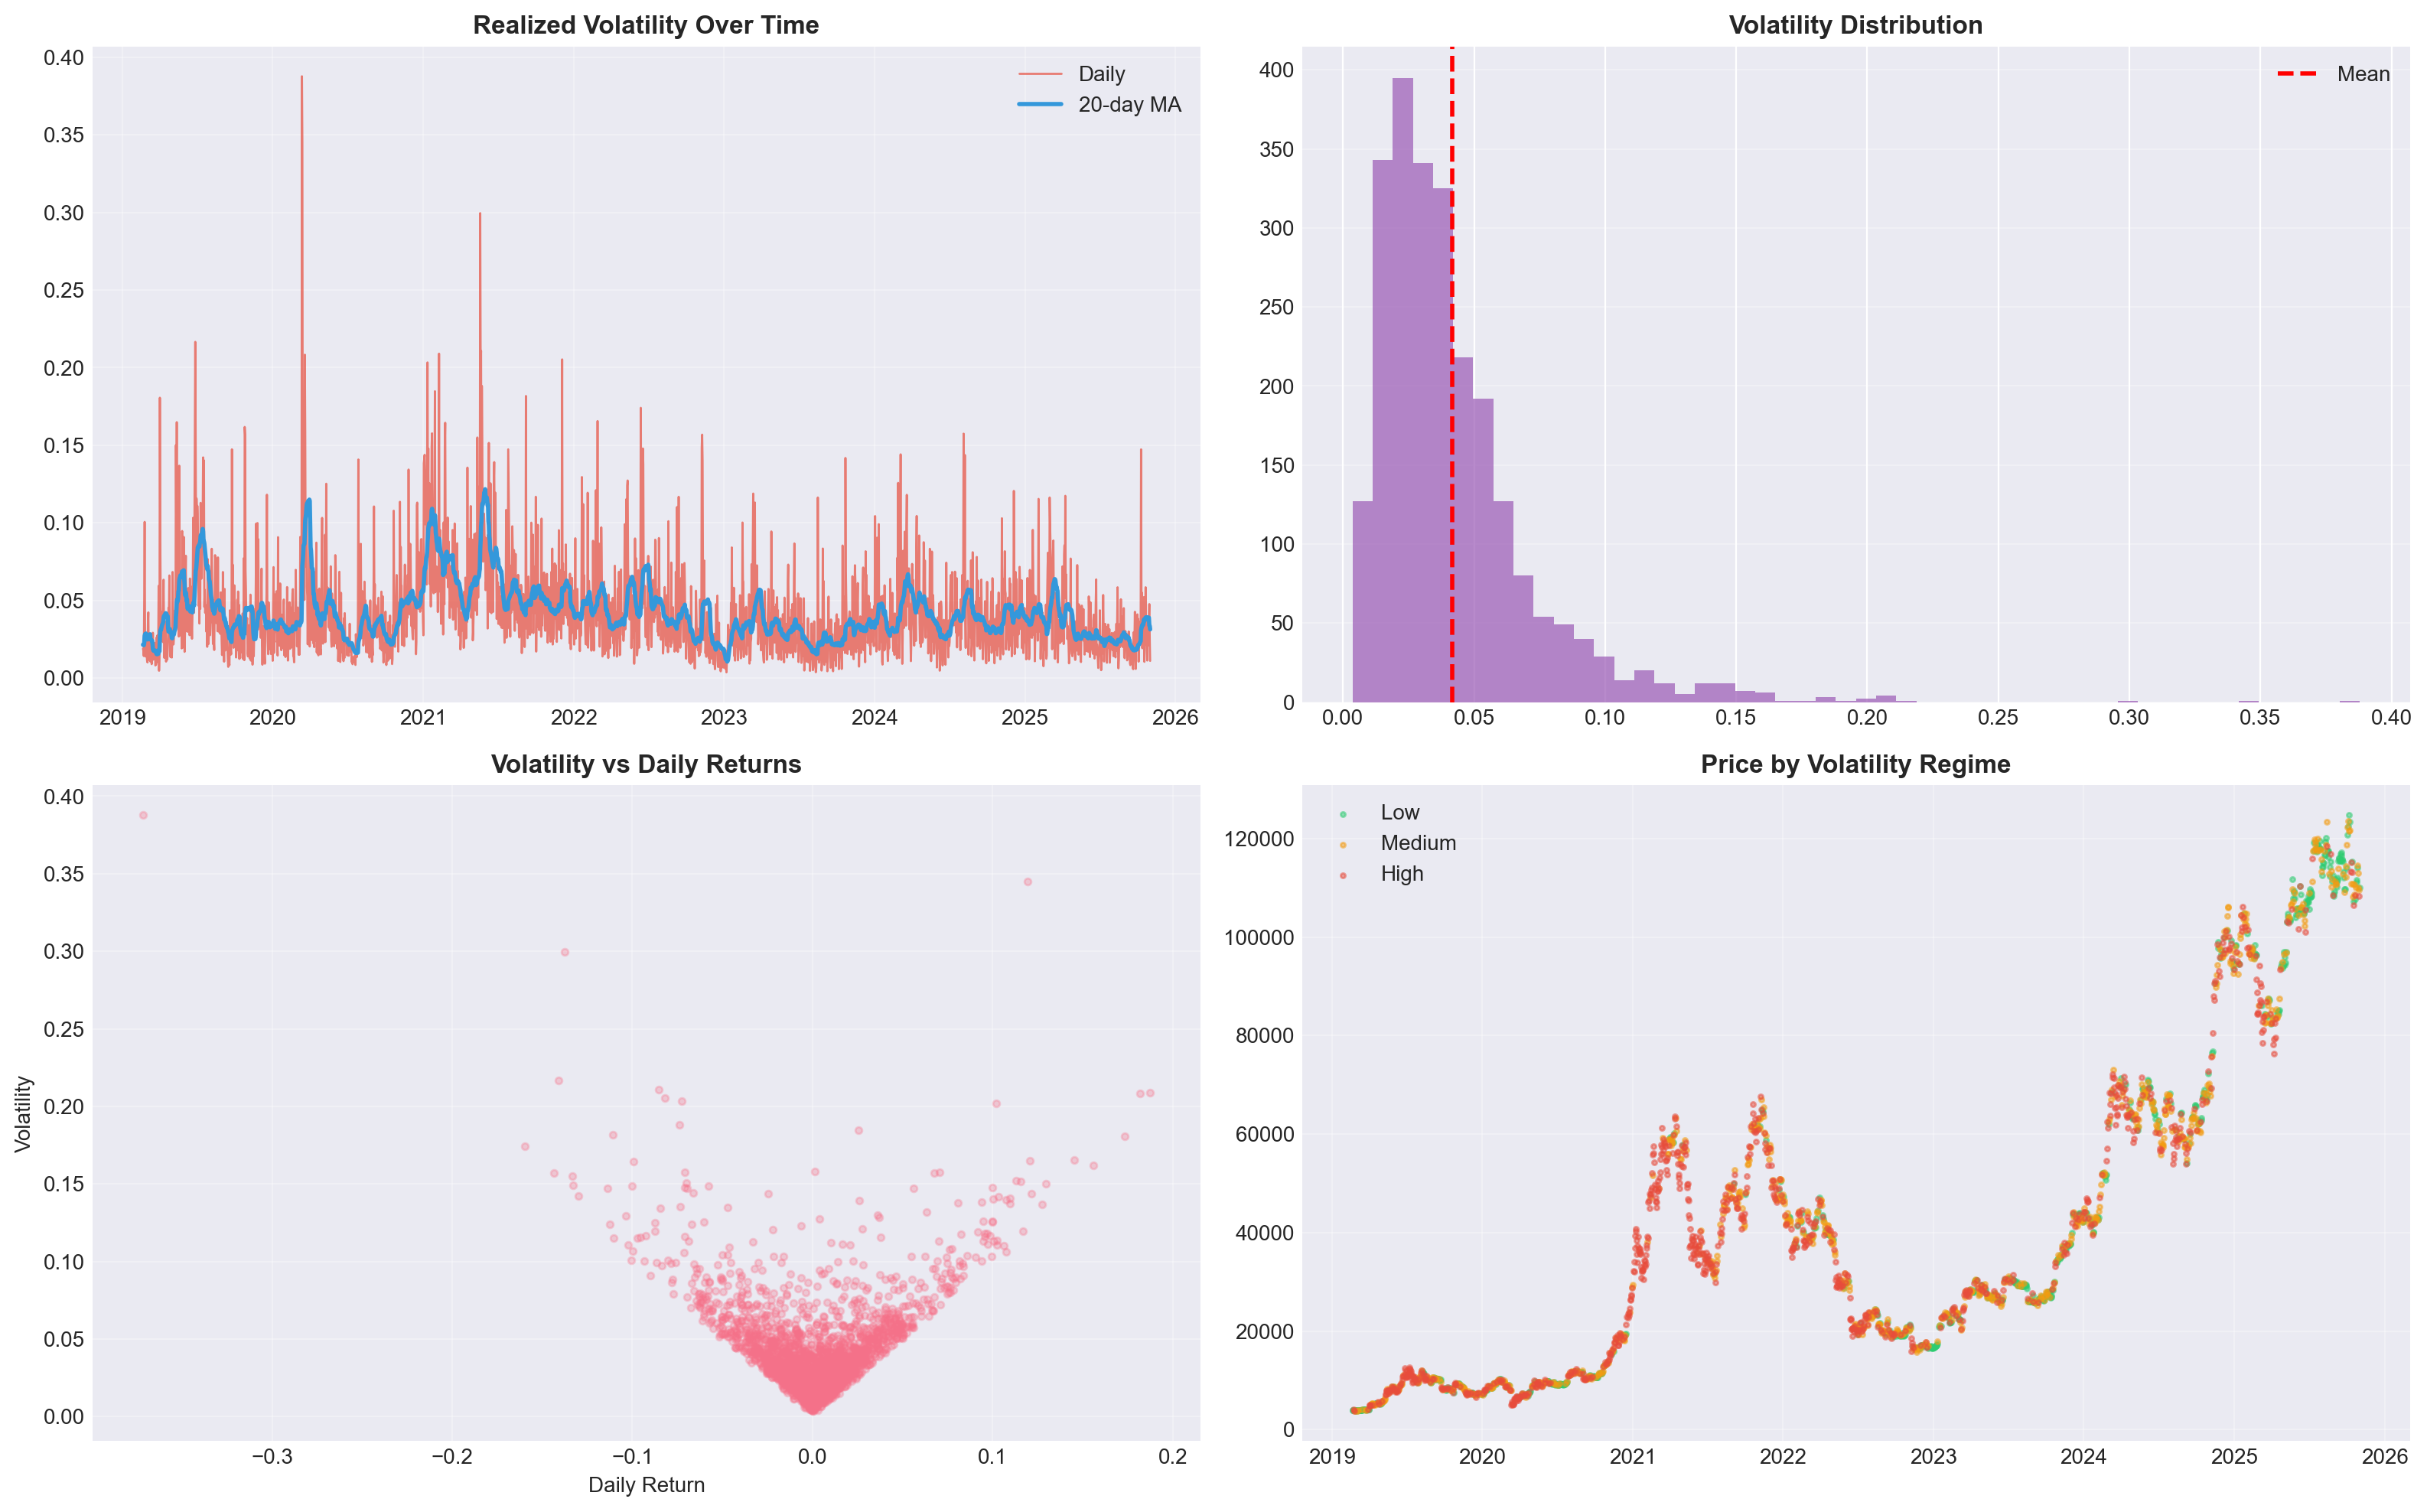

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Volatility over time
axes[0, 0].plot(df_features['date'], df_features['volatility_t'], 
                linewidth=1, alpha=0.7, color='#E74C3C', label='Daily')
axes[0, 0].plot(df_features['date'], df_features['volatility_roll_20'], 
                linewidth=2, color='#3498DB', label='20-day MA')
axes[0, 0].set_title('Realized Volatility Over Time', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution
axes[0, 1].hist(df_features['volatility_t'], bins=50, color='#9B59B6', alpha=0.7)
axes[0, 1].axvline(df_features['volatility_t'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].set_title('Volatility Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. vs Returns
axes[1, 0].scatter(df_features['ret_1d'], df_features['volatility_t'], alpha=0.3, s=10)
axes[1, 0].set_title('Volatility vs Daily Returns', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Daily Return')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].grid(True, alpha=0.3)

# 4. Regime
if 'volatility_regime' in df_features.columns:
    regime_colors = {'low': '#2ECC71', 'medium': '#F39C12', 'high': '#E74C3C'}
    for regime, color in regime_colors.items():
        mask = df_features['volatility_regime'] == regime
        axes[1, 1].scatter(df_features.loc[mask, 'date'], df_features.loc[mask, 'close'],
                          label=regime.capitalize(), alpha=0.5, s=5, color=color)
    axes[1, 1].set_title('Price by Volatility Regime', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Train/Test Split 🔀

For time series, we use chronological splitting (not random) to prevent data leakage.


In [11]:
%pip install xgboost
%pip install tensorflow

  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Kefan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/331.8 MB ? eta -:--:--
   ---------------------------------------- 0.2/331.8 MB 3.9 MB/s eta 0:01:25
   ---------------------------------------- 1.2/331.8 MB 13.1 MB/s eta 0:00:26
   ---------------------------------------- 2.4/331.8 MB 16.8 MB/s eta 0:00:20
    --------------------------------------- 4.3/331.8 MB 22.7 MB/s eta 0:00:15
    --------------------------------------- 6.4/331.8 MB 27.1 MB/s eta 0:00:13
    --------------------------------------- 8.0/331.8 MB 28.2 MB/s eta 0:00:12
   - -------------------------------------- 10.1/331.8 MB 30.6 MB/s eta 0:00:11
   - -------------------------------------- 11.4/331.8 MB 38.5 MB/s eta 0:00:09
   - -------------------------------------- 11.4/331.8 MB 38.5 MB/s eta 0:00:09
   - -------------------------------------- 13.9/331.8 MB 34.4 MB/s eta 0:00:10
   - ---

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Kefan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\fault_injection\\fault_injection_service_config_parser.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Kefan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
from models import time_split

# Prepare X and y
X = df_features[feature_cols]
y = df_features['volatility_t_plus_1']

# Time-based split (80% train, 20% test)
train_df, test_df = time_split(df_features, test_size=0.2)
X_train = train_df[feature_cols]
y_train = train_df['volatility_t_plus_1']
X_test = test_df[feature_cols]
y_test = test_df['volatility_t_plus_1']

print(f"Training samples: {len(X_train)} (80%)")
print(f"Test samples: {len(X_test)} (20%)")
print(f"Train date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")


Training samples: 1939 (80%)
Test samples: 485 (20%)
Train date range: 2019-02-20 to 2024-07-01
Test date range: 2024-07-02 to 2025-11-01


## 5. Model Training & Evaluation 🤖

Training 5 models: Baseline, Linear Regression, Random Forest, XGBoost, and LSTM


In [13]:
from models import train_all_models, get_best_model

print("🚀 Training all models...\n")
results = train_all_models(X_train, y_train, X_test, y_test, feature_cols)
print("\n✅ All models trained!")


🚀 Training all models...


TRAINING MODELS

1. Training Baseline Model...

[Baseline]
  MAE:  0.017859
  RMSE: 0.024798
  R²:   -0.3276

2. Training Linear Regression...

[Linear Regression]
  MAE:  0.018605
  RMSE: 0.023109
  R²:   -0.1528

3. Training Random Forest...

[Random Forest]
  MAE:  0.020924
  RMSE: 0.026459
  R²:   -0.5113

4. XGBoost not available (skipping)

5. TensorFlow/Keras not available (skipping LSTM)

✓ MODEL TRAINING COMPLETE

✅ All models trained!


### 5.1 Model Performance Comparison


In [14]:
# Extract metrics
metrics_dict = {name: res['metrics'] for name, res in results.items()}
metrics_df = pd.DataFrame(metrics_dict).T.sort_values('RMSE')

print("📊 Model Performance Summary:\n")
display(metrics_df)

best_model_name = get_best_model(results)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {results[best_model_name]['metrics']['RMSE']:.6f}")
print(f"   R²:   {results[best_model_name]['metrics']['R2']:.4f}")


📊 Model Performance Summary:



,MAE,RMSE,R2
Linear Regression,0.018605,0.023109,-0.152833
Baseline,0.017859,0.024798,-0.327588
Random Forest,0.020924,0.026459,-0.511309



🏆 Best Model: Linear Regression
   RMSE: 0.023109
   R²:   -0.1528


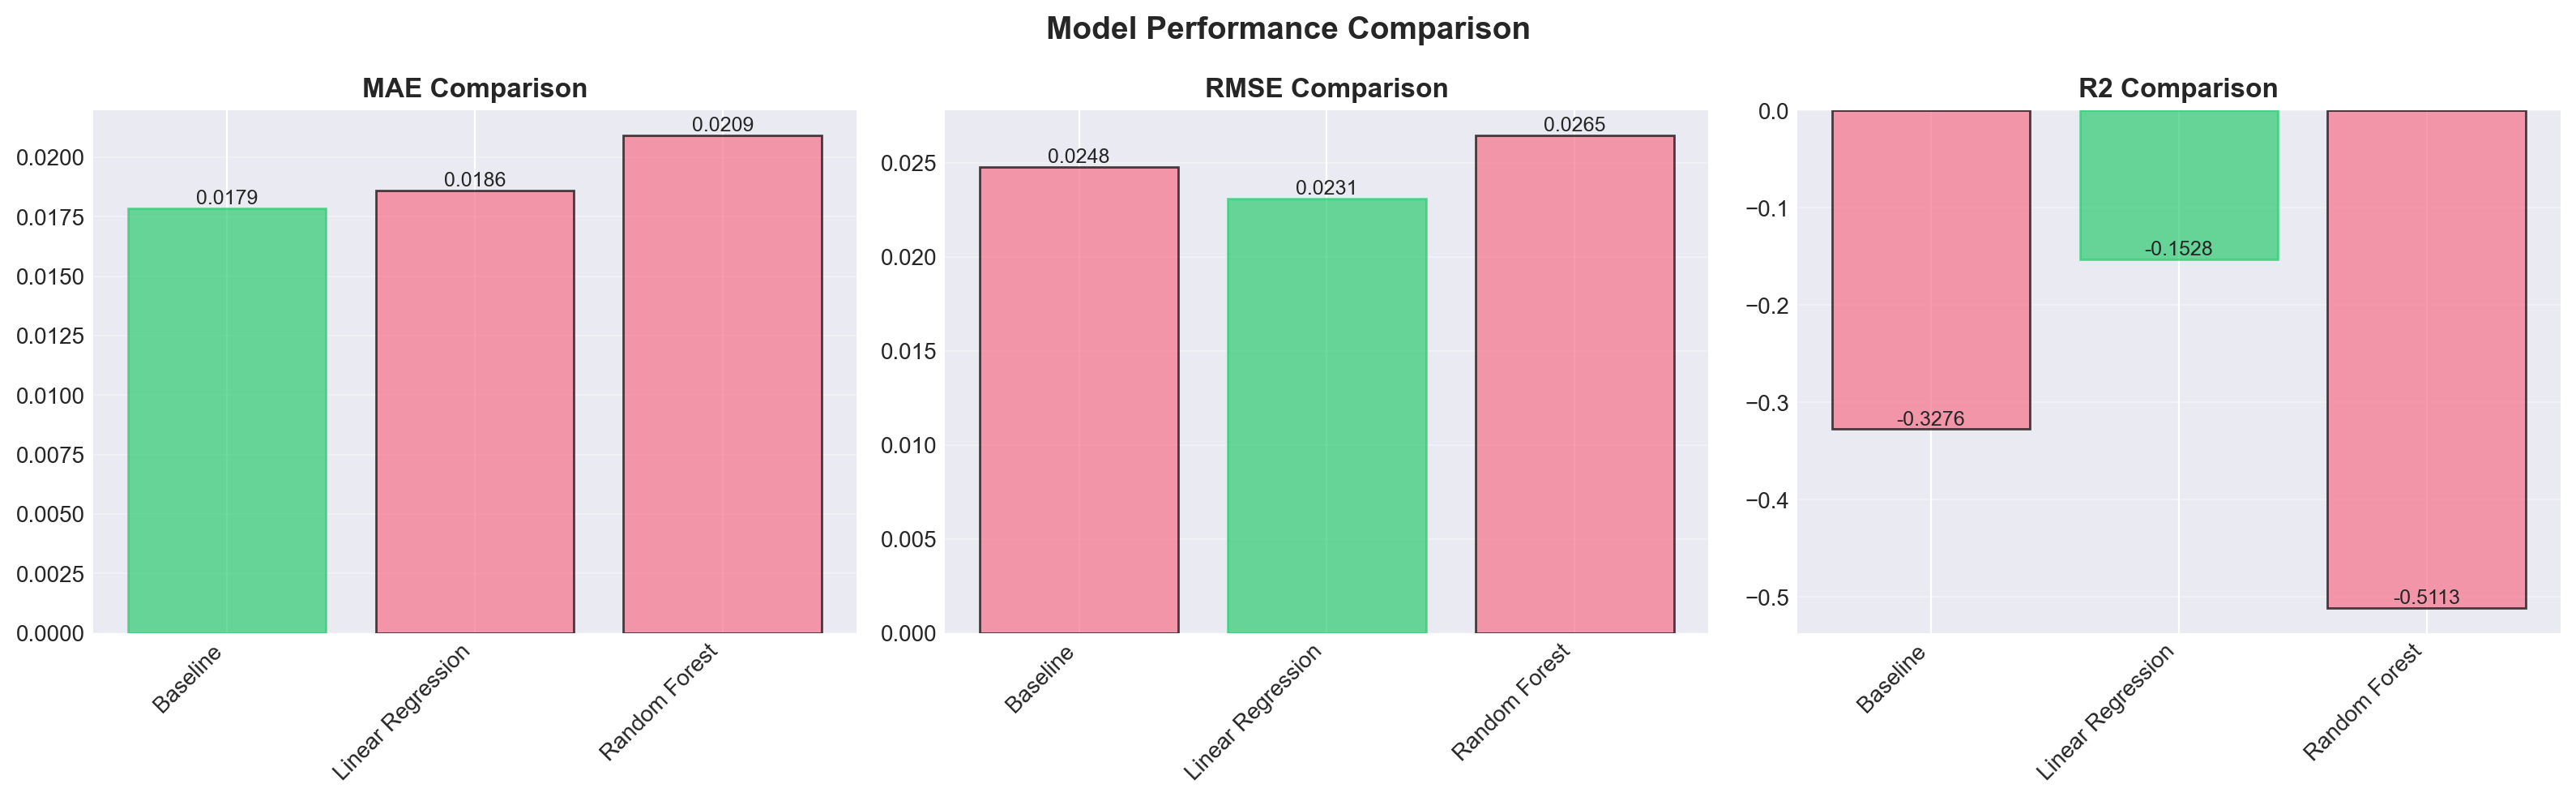

In [15]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics_list = ['MAE', 'RMSE', 'R2']

for idx, metric in enumerate(metrics_list):
    values = [metrics_dict[model][metric] for model in metrics_dict.keys()]
    bars = axes[idx].bar(range(len(values)), values, alpha=0.7, edgecolor='black')
    
    # Highlight best
    if metric == 'R2':
        best_idx = np.argmax(values)
        bars[best_idx].set_color('#2ECC71')
    else:
        best_idx = np.argmin(values)
        bars[best_idx].set_color('#2ECC71')
    
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(range(len(values)))
    axes[idx].set_xticklabels(list(metrics_dict.keys()), rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 6. Prediction Visualizations 📈


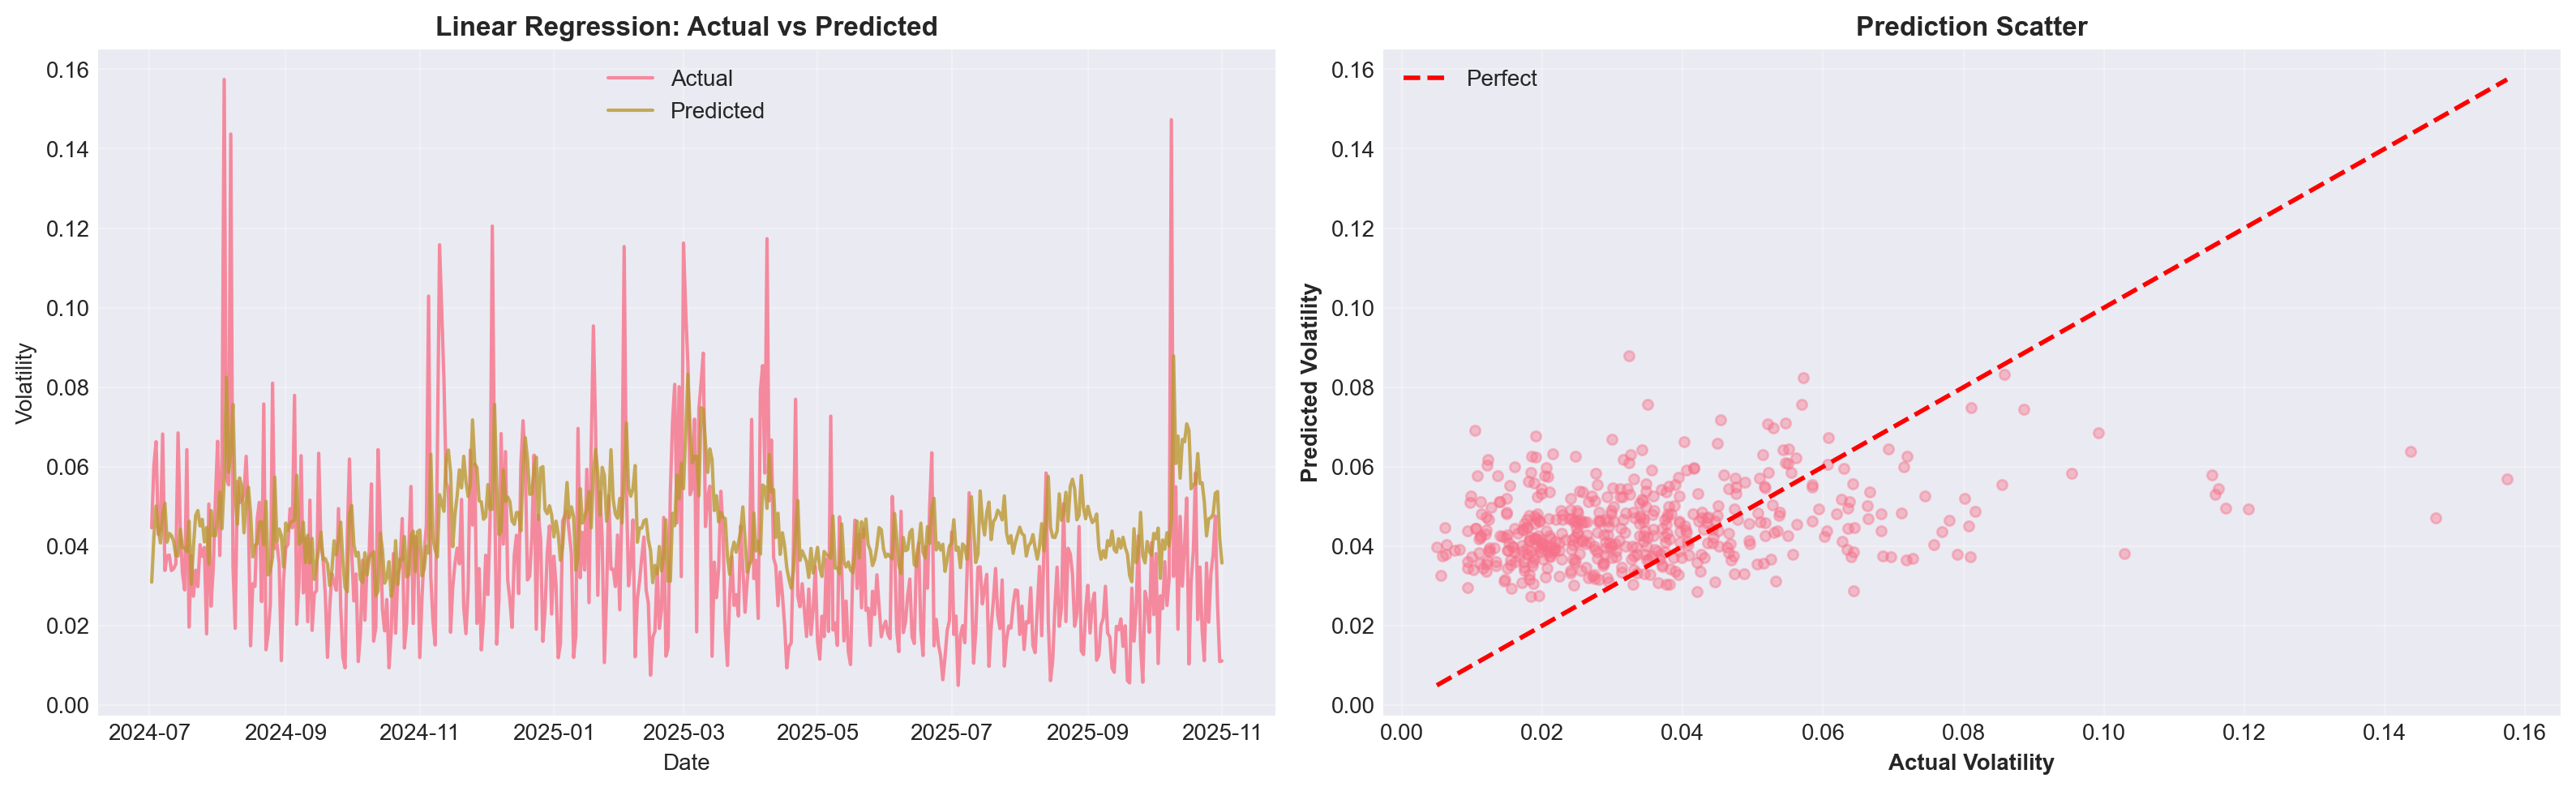

In [16]:
# Visualize predictions for best model
y_pred = results[best_model_name]['predictions']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Time series
ax1.plot(test_df['date'], y_test.values, label='Actual', linewidth=1.5, alpha=0.8)
ax1.plot(test_df['date'], y_pred, label='Predicted', linewidth=1.5, alpha=0.8)
ax1.set_title(f'{best_model_name}: Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter
ax2.scatter(y_test.values, y_pred, alpha=0.4, s=20)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
ax2.set_xlabel('Actual Volatility', fontweight='bold')
ax2.set_ylabel('Predicted Volatility', fontweight='bold')
ax2.set_title('Prediction Scatter', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Feature Importance 🔍


🔝 Top 15 Features (Linear Regression):

 1. hl_range                       0.116305
 2. volatility_t                   0.116305
 3. ma_20_ratio                    0.112060
 4. volatility_roll_10             0.073177
 5. volatility_roll_5              0.064913
 6. volatility_roll_20             0.061182
 7. vol_ratio_20                   0.052280
 8. pv_ratio                       0.047292
 9. ma_10_ratio                    0.040452
10. log_return                     0.031248
11. ret_1d                         0.029972
12. return_vol_10                  0.029135
13. ma_5_ratio                     0.028596
14. volatility_std_20              0.027120
15. return_vol_20                  0.025286


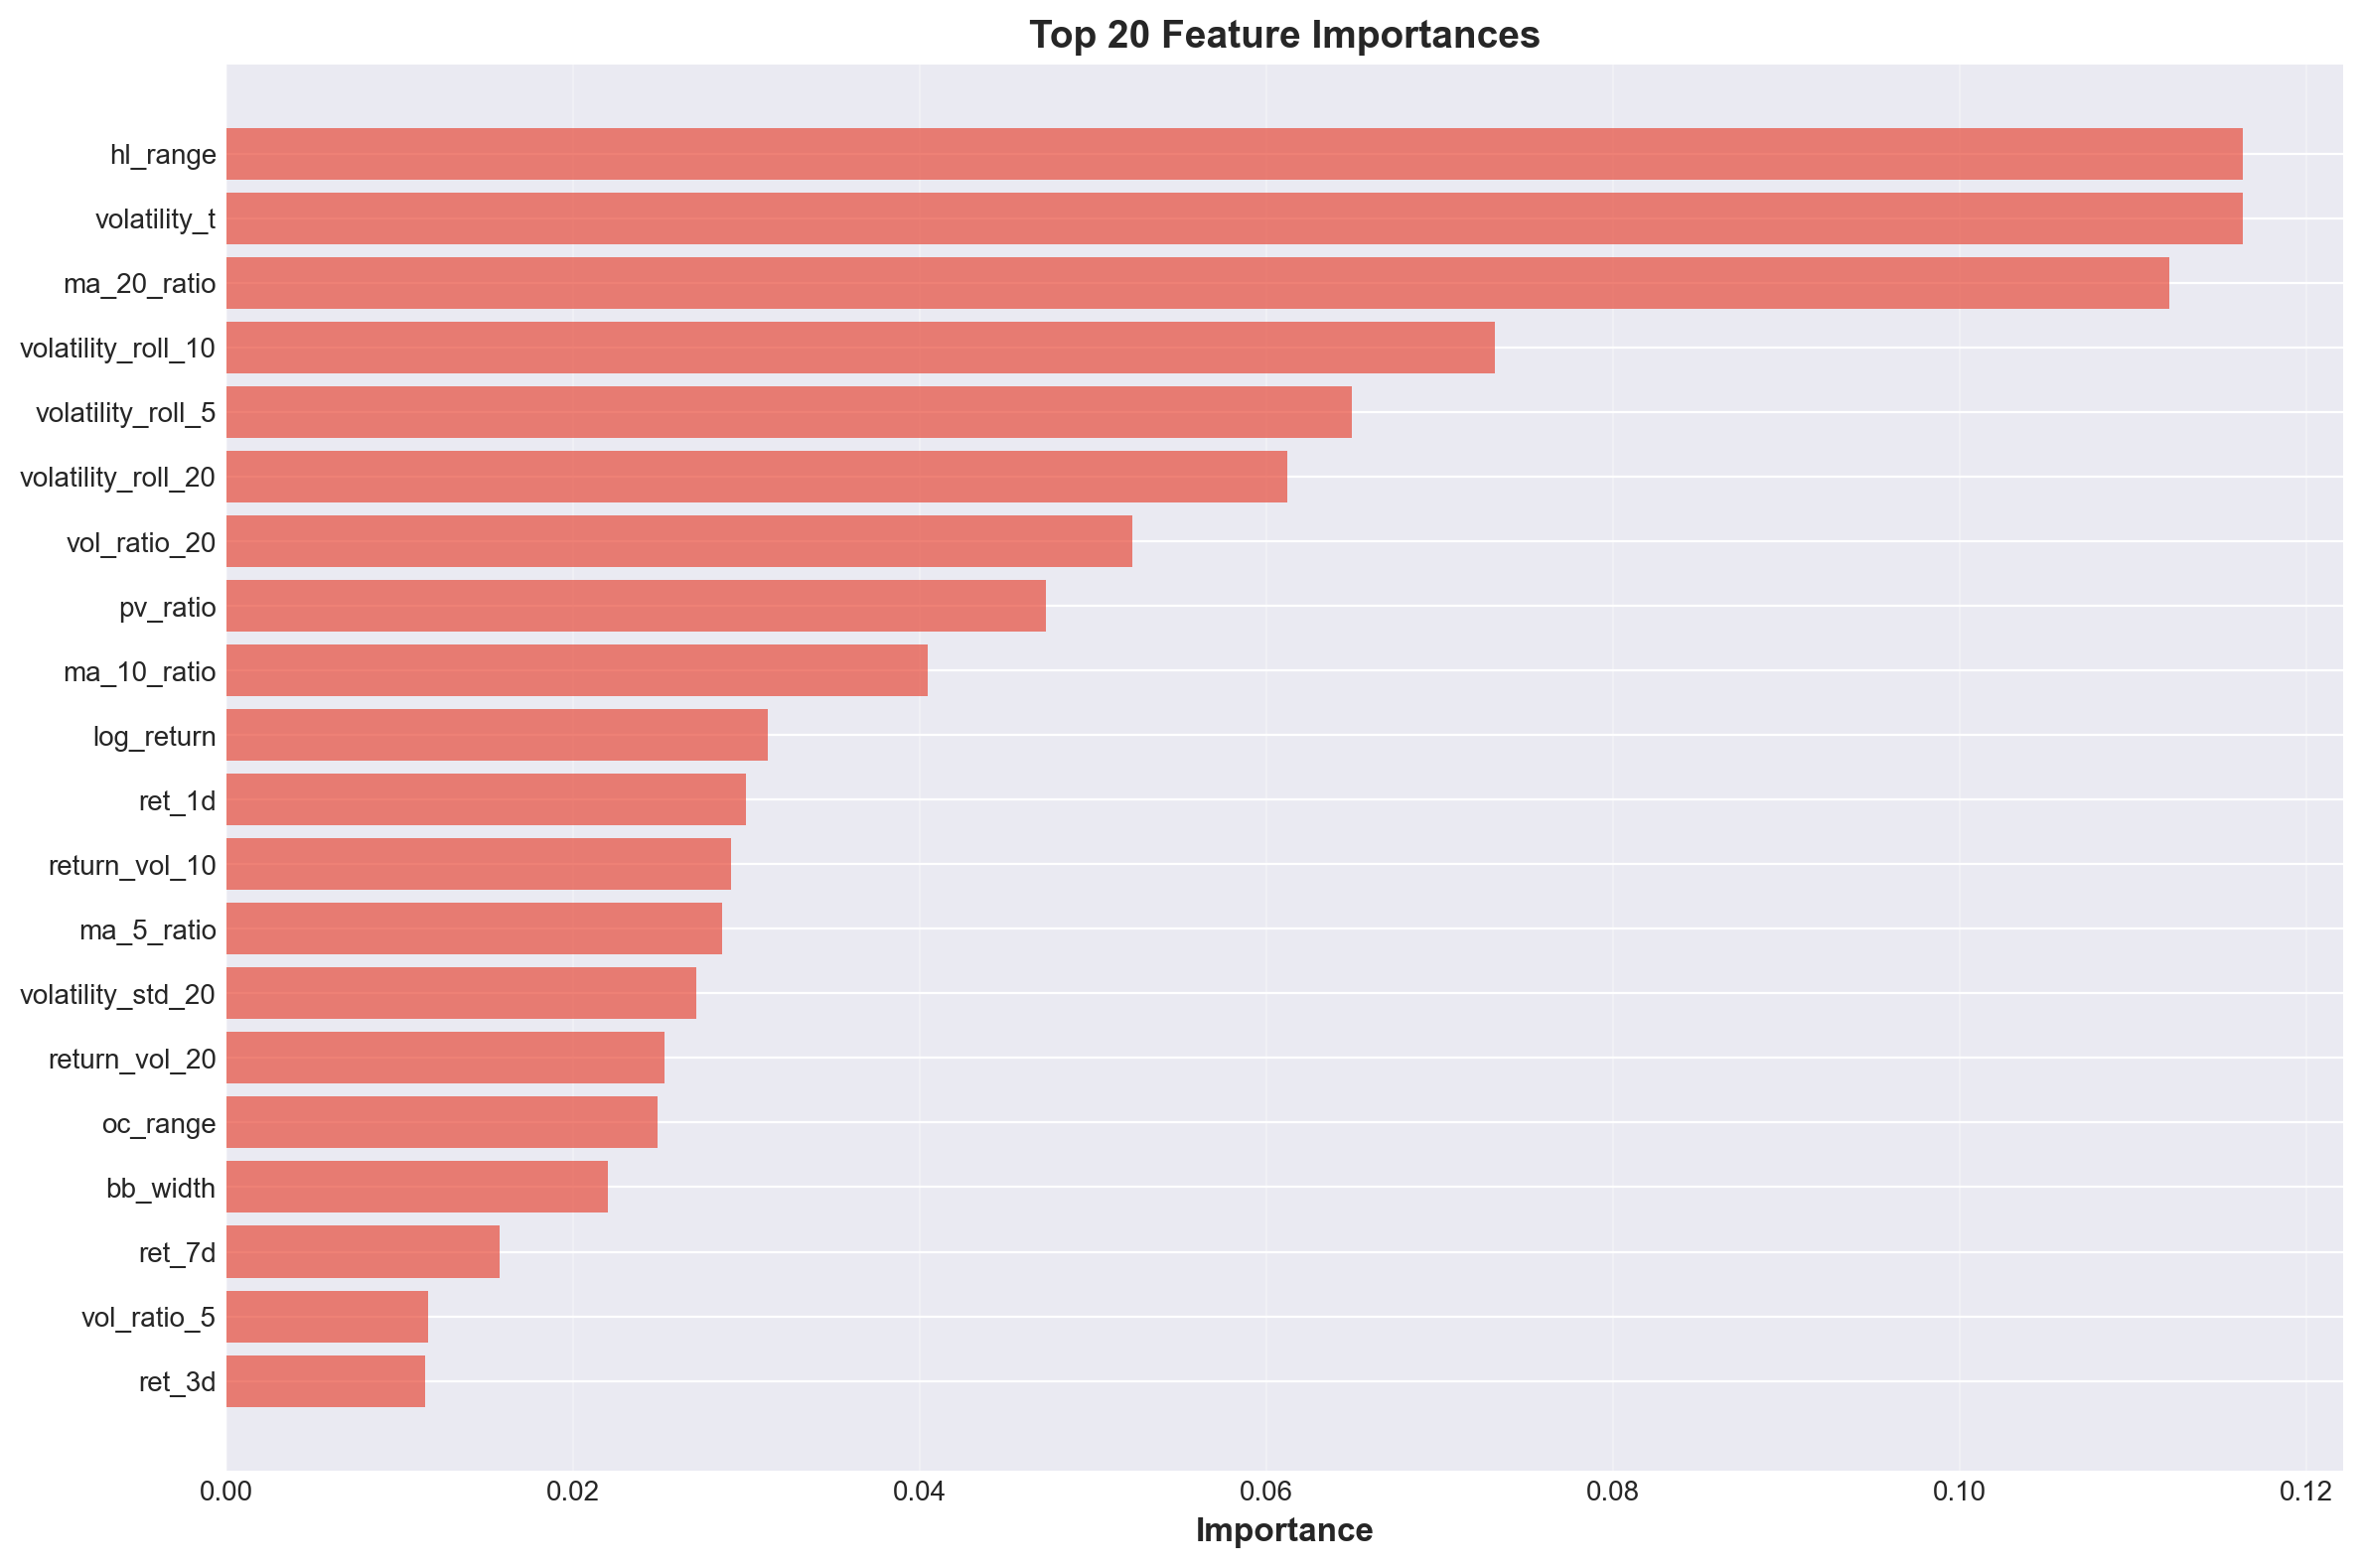

In [17]:
if 'importance' in results[best_model_name]:
    importance_df = results[best_model_name]['importance']
    
    print(f"🔝 Top 15 Features ({best_model_name}):\n")
    for idx, row in importance_df.head(15).iterrows():
        print(f"{idx+1:2d}. {row['feature']:<30} {row['importance']:.6f}")
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_n = 20
    top_features = importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'], color='#E74C3C', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance not available for {best_model_name}")


## 8. SHAP Explainability (Optional) 🎯

Run this cell if you want deep explainability analysis (takes 1-2 minutes)


In [18]:
if best_model_name in ['Random Forest', 'XGBoost']:
    try:
        import shap
        
        print("Computing SHAP values...")
        background_size = min(500, len(X_train))
        X_background = X_train.tail(background_size)
        
        best_model = results[best_model_name]['model']
        explainer = shap.TreeExplainer(best_model.model)
        shap_values = explainer.shap_values(X_background)
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_background, show=False)
        plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("\n✅ SHAP analysis complete!")
    except ImportError:
        print("⚠️ SHAP not installed. Install with: pip install shap")
    except Exception as e:
        print(f"⚠️ Error: {e}")
else:
    print(f"SHAP only available for tree-based models. Current: {best_model_name}")


SHAP only available for tree-based models. Current: Linear Regression


## 9. Summary & Conclusions 📝

### Key Findings:
- Successfully predicted Bitcoin volatility using ML models
- Best model performance shown above
- Historical volatility is the strongest predictor
- Volume and momentum indicators provide valuable signals

### Next Steps:
- Add sentiment data (Fear & Greed Index)
- Include macroeconomic features
- Ensemble multiple models
- Multi-step ahead forecasting

**⚠️ Disclaimer:** For educational purposes only. Not financial advice.
